# Attack on Firmware Implementation of AES (Acquisition + Visualization + DPA + CPA) based on CW code :-)

First you'll need to select which hardware setup you have. You'll need to select a `SCOPETYPE`, a `PLATFORM`, and a `CRYPTO_TARGET`. `SCOPETYPE` can either be `'OPENADC'` for the CWLite/CW1200 or `'CWNANO'` for the CWNano. `PLATFORM` is the target device, with `'CWLITEARM'`/`'CW308_STM32F3'` being the best supported option, followed by `'CWLITEXMEGA'`/`'CW308_XMEGA'`, then by `'CWNANO'`. `CRYPTO_TARGET` selects the crypto implementation, with `'TINYAES128C'` working on all platforms. An alternative for `'CWLITEXMEGA'` targets is `'AVRCRYPTOLIB'`. For example:

```python
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'
```

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWNANO'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

The following code will build the firmware for the target.

In [2]:
%run "../../Setup_Scripts/Setup_Generic.ipynb"

(ChipWhisperer Other WARNING|File __init__.py:69) ChipWhisperer update available! See https://chipwhisperer.readthedocs.io/en/latest/installing.html for updating instructions


INFO: Found ChipWhisperer😍


In [3]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-aes
make PLATFORM=$1 CRYPTO_TARGET=$2 SS_VER=$3

Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
make clean_objs .dep 
make[1]: Entering directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmware/simpleserial-aes'
Building for platform CWNANO with CRYPTO_TARGET=TINYAES128C
SS_VER set to SS_VER_1_1
Blank crypto options, building for AES128
rm -f -- simpleserial-aes-CWNANO.hex
rm -f -- simpleserial-aes-CWNANO.eep
rm -f -- simpleserial-aes-CWNANO.cof
rm -f -- simpleserial-aes-CWNANO.elf
rm -f -- simpleserial-aes-CWNANO.map
rm -f -- simpleserial-aes-CWNANO.sym
rm -f -- simpleserial-aes-CWNANO.lss
rm -f -- objdir-CWNANO/*.o
rm -f -- objdir-CWNANO/*.lst
rm -f -- simpleserial-aes.s simpleserial.s stm32f0_hal_nano.s stm32f0_hal_lowlevel.s aes.s aes-independant.s
rm -f -- simpleserial-aes.d simpleserial.d stm32f0_hal_nano.d stm32f0_hal_lowlevel.d aes.d aes-independant.d
rm -f -- simpleserial-aes.i simpleserial.i stm32f0_hal_nano.i stm32f0_hal_lo

simpleserial-aes.c: In function 'get_pt':
simpleserial-aes.c:44:3: warning: this 'for' clause does not guard... [-Wmisleading-indentation]
   for (volatile uint8_t k = 0; k < (*pt & 0x0F); k++);
   ^~~
simpleserial-aes.c:47:2: note: ...this statement, but the latter is misleadingly indented as if it were guarded by the 'for'
  aes_indep_enc(pt); /* encrypting the data block */
  ^~~~~~~~~~~~~


.
Compiling C: .././simpleserial/simpleserial.c
arm-none-eabi-gcc -c -mcpu=cortex-m0 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F030x6 -DSTM32F0 -DSTM32 -DDEBUG -DHAL_TYPE=HAL_stm32f0_nano -DPLATFORM=CWNANO -DTINYAES128C -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CWNANO/simpleserial.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f0 -I.././hal/stm32f0/CMSIS -I.././hal/stm32f0/CMSIS/core -I.././hal/stm32f0/CMSIS/device -I.././hal/stm32f0/Legacy -I.././crypto/ -I.././crypto/tiny-AES128-C -std=gnu99  -MMD -MP -MF .dep/simpleserial.o.d .././simpleserial/simpleserial.c -o objdir-CWNANO/simpleserial.o
.
Compiling C: .././hal/stm32f0_nano/stm32f0_hal_nano.c
arm-none-eabi-gcc -c -mcpu=cortex-m0 -I. -DNO_EXTRA_OPTS -mthumb -mfloat-abi=soft -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F030

In [4]:
cw.program_target(scope, prog, "../../../hardware/victims/firmware/simpleserial-aes/simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6247 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6247 bytes


NANO is noisy, let's take 10000 :-D !

In [5]:
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

key, text = ktp.next()

target.set_key(key)

N = 1000 #increase nano reliability
if PLATFORM=="CWNANO":
    N = 200
for i in trange(N, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', text)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 16)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(text)
    
    key, text = ktp.next()
    
trace_array = np.array(trace_array)

Capturing traces:   0%|          | 0/200 [00:00<?, ?it/s]

We don't need the hardware anymore, so we'll disconnect:

In [6]:
scope.dis()
target.dis()

### Plot the first and last trace using matplotlib. Use for example:
%matplotlib notebook

import matplotlib.pylab as plt

Also please print the input to the first trace and the key. 

<IPython.core.display.Javascript object>


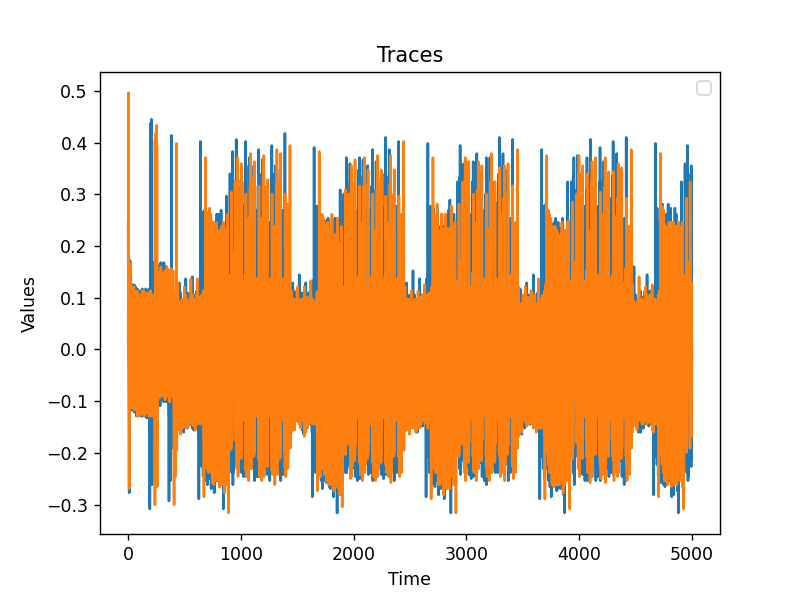

CWbytearray(b'4b 38 ef 8a ff f9 70 08 f7 43 0f db e9 30 86 ce')
CWbytearray(b'2b 7e 15 16 28 ae d2 a6 ab f7 15 88 09 cf 4f 3c')


In [7]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
plt.plot(trace_array[0])
plt.plot(trace_array[199])
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Traces")
plt.legend()
plt.show()
print(textin_array[0])
print(key)

## Different settings for acquistion

### Please experiment with different settings for acquision. 

Check:
https://chipwhisperer.readthedocs.io/en/latest/scope-api.html#api-scope-cwnano

Try modyfying: scope.adc.samples 

Read and print other settings of scope.adc 

## Alignment

### The traces seems very aligned. Why do you think it is the case? 

How would you implement countermeasures here?Which code is actually run?

Let's concentrate on random delays. 

### Recombile the code for random delays and check the traces. 





## How to write and read traces and data?

In [ ]:
np_traces = np.asarray(trace_array)
np_textins = np.asarray(textin_array)
np.save('./traces.npy', np_traces)
np.save('./textins.npy', np_textins)

## How to read traces and data?

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt


trace_array2 = np.load('./traces.npy')
textin_array2 = np.load('./textins.npy')

plt.figure()
plt.plot(trace_array2[1])
plt.plot(trace_array2[199])
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Read Traces")
plt.legend()
plt.show()
print(textin_array[0])
print(key)

## Helper code. What do you see below?

In [ ]:
# ###################
# START HELP
# ###################
sbox = [
    # 0    1    2    3    4    5    6    7    8    9    a    b    c    d    e    f
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76, # 0
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0, # 1
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15, # 2
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75, # 3
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84, # 4
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf, # 5
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8, # 6
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2, # 7
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73, # 8
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb, # 9
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79, # a
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08, # b
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a, # c
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e, # d
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf, # e
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16  # f
]

def aes_internal(inputdata, key):
    return sbox[inputdata ^ key]

HW = [bin(n).count("1") for n in range(0, 256)]

assert HW[aes_internal(0xA1, 0x79)] == 3
assert HW[aes_internal(0x22, 0xB1)] == 5
print("✔️ OK to continue!")

def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)
# ###################
# END HELP
# ###################

## Correlate Input and Output bytes to the traces themselves. 

## Implement DPA for one key byte using the most significant bit of the sbox output in round 1. 

### Plot the correct differential trace (can be also after absolute).

## Implement CPA for one byte. How many traces do you need? 

### Plot the correct correlation trace (can be also after absolute).

## Implement CPA for all bytes. Run it!